In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results
from sklearn import preprocessing
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
ACTOR = "genscen_Deventer_50000_12-06-2021-02-25-33.tar.gz"

In [3]:
experiments, outcomes = load_results("simulation/generated/" + ACTOR)
dike_model, planning_steps = get_model_for_problem_formulation("Deventer")
uncertainties = [uncertainty.name for uncertainty in dike_model.uncertainties]
x = experiments[uncertainties]
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Deventer Expected Annual Damage',
 'Deventer Expected Number of Deaths',
 'Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_

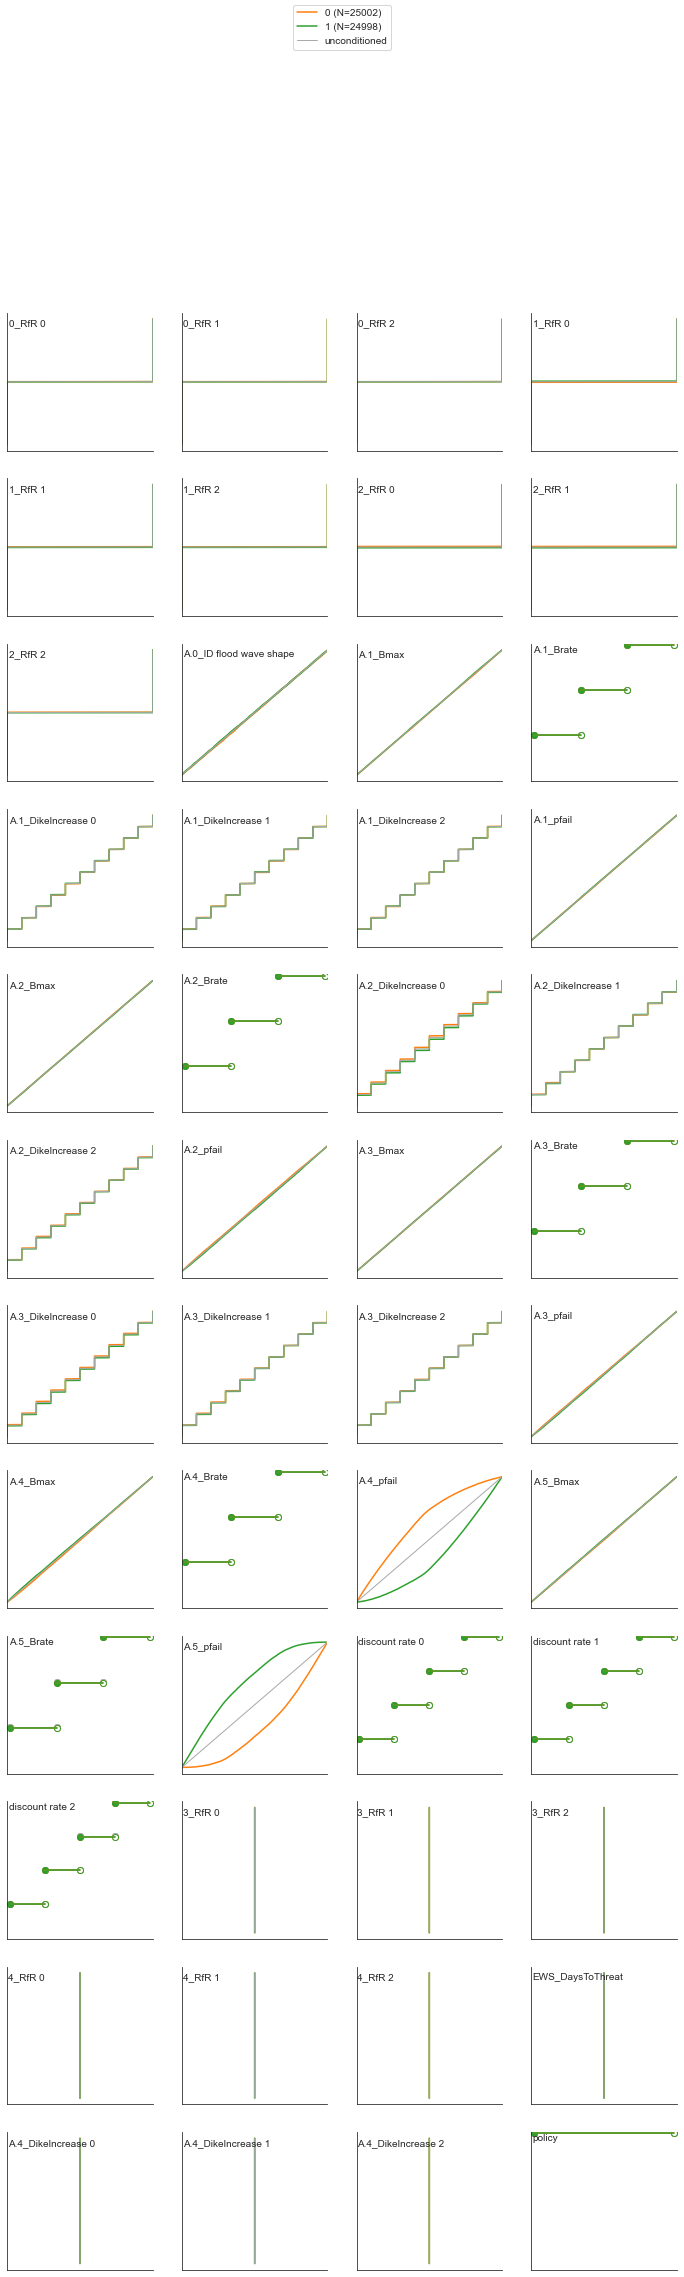

In [6]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style('white')

# model is the same across experiments
x = experiments.copy()
x = x.drop('model', axis=1)
y = outcomes[DEATHS] >  np.percentile(a=outcomes_df[DEATHS], q=50)
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

Just as sensitivity analsyis showed, the outcomes are most sensitivie to A.4_pfail and A.5_pfail.

In [7]:
outcomes_df.describe(percentiles=np.arange(0, 1, 0.1))

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
count,5.000000e+04,50000.000000,50000.0
mean,1.811865e+08,0.165814,0.0
std,2.724127e+08,0.241198,0.0
min,0.000000e+00,0.000000,0.0
0%,0.000000e+00,0.000000,0.0
10%,0.000000e+00,0.000000,0.0
20%,0.000000e+00,0.000000,0.0
30%,0.000000e+00,0.000000,0.0
40%,1.988556e+07,0.019655,0.0
50%,5.698603e+07,0.055319,0.0


Obviously, without any policies inplace, there also aren't any costs for Deventer.

In [8]:
prim_algs = {}
percentiles = [40, 90]

def conditional(outcome, q):
    global percentiles
    if q == percentiles[0]:
        return outcomes_df[outcome] < np.percentile(a=outcomes_df[outcome], q=q)
    elif q == percentiles[1]:
        return outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=q)  
            
for q in percentiles:
    prim_algs[q] = {}   
    for outcome in [DAMAGE, DEATHS]:
        #code block below performs a rotation of data
    #     x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
    #     x_categorical = x.select_dtypes(include=pd.CategoricalDtype)
    #     rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=q))
    #     rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
    #     rotated_x.columns = x_numeric.columns.tolist() + x_categorical.columns.tolist()
    #     x = rotated_x

        prim_algs[q][outcome] = prim.Prim(x,  conditional(outcome, q), threshold=0.8)

We opted for the lowest 40th percentile, as anything lower than that would not contain enoufh information to run for prim. Interesting.

In [9]:
outcomes_df.quantile([0, .2])

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0


In [10]:
outcomes_df.quantile([0, .4])

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0.0,0.000000e+00,0.000000,0.0
0.4,1.988556e+07,0.019655,0.0


In [11]:
boxes = {}
for upperkey in percentiles:
    boxes[upperkey] = {}
    for lowerkey in [DAMAGE, DEATHS]:
        boxes[upperkey][lowerkey] = prim_algs[upperkey][lowerkey].find_box()

40


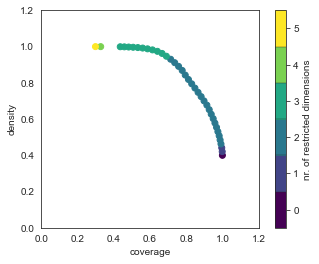

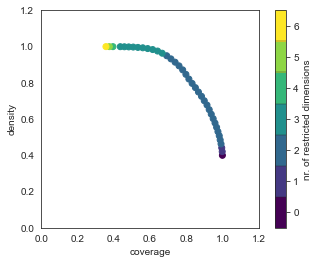

90


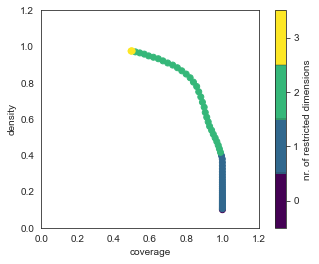

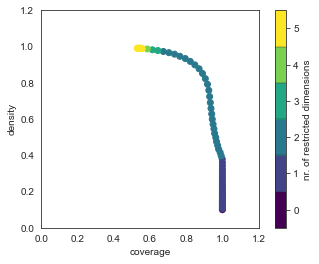

In [12]:
for upperkey, percentile in boxes.items():
    print(upperkey)
    for lowerkey, box in percentile.items():
        box.show_tradeoff()
        plt.show()

# Trying around to find the right box
Only going to explore A.5_pfail for now, as the outcomes seem most sensitive to that, based on the results of SA_mod.
## Damage

coverage     0.81265
density     0.818585
id                18
mass          0.3971
mean        0.818585
res_dim            2
Name: 18, dtype: object

                 box 18                       
                    min       max    qp values
A.4_pfail  4.683069e-07  0.568660  [-1.0, 0.0]
A.5_pfail  3.016385e-01  0.999992  [0.0, -1.0]



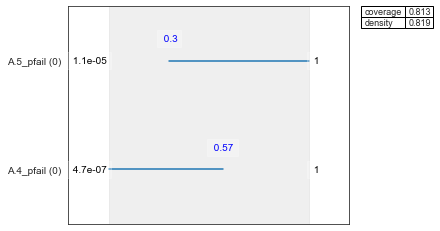

In [13]:
box_id=18
BOX = DAMAGE
boxes[percentiles[0]][BOX].inspect(box_id)
boxes[percentiles[0]][BOX].inspect(box_id, style='graph')
plt.show()

In [14]:
lims = boxes[percentiles[0]][BOX].box_lims[box_id]
limits = pd.DataFrame(data={"outcome": ["damage " + str(percentiles[0])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})

coverage      0.8402
density     0.804019
id                44
mass          0.1045
mean        0.804019
res_dim            2
Name: 44, dtype: object

             box 44                                          
                min       max                       qp values
A.5_pfail  0.000011  0.116059                     [-1.0, 0.0]
A.4_pfail  0.097408  0.999984  [1.3617141444186901e-24, -1.0]



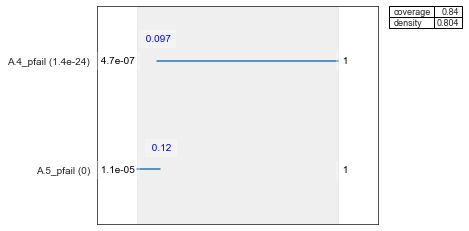

In [15]:
box_id=44
BOX = DAMAGE
boxes[percentiles[1]][BOX].inspect(box_id)
boxes[percentiles[1]][BOX].inspect(box_id, style='graph')
plt.show()

In [16]:
lims = boxes[percentiles[1]][BOX].box_lims[box_id]
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["damage " + str(percentiles[1])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

In [17]:
limits

,outcome,min,max
0,damage 40,0.301639,0.999992
0,damage 90,0.000011,0.116059


## Deaths

In [18]:
box_id=17
BOX = DEATHS

coverage     0.8328
density      0.7969
id               17
mass        0.41802
mean         0.7969
res_dim           2
Name: 17, dtype: object

                 box 17                       
                    min       max    qp values
A.4_pfail  4.683069e-07  0.568342  [-1.0, 0.0]
A.5_pfail  2.649845e-01  0.999992  [0.0, -1.0]



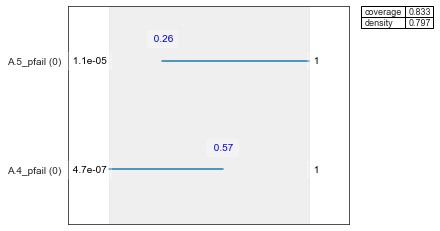

In [19]:
boxes[percentiles[0]][BOX].inspect(box_id)
boxes[percentiles[0]][BOX].inspect(box_id, style='graph')
plt.show()

In [20]:
lims = boxes[percentiles[0]][BOX].box_lims[box_id]

In [21]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["deaths " + str(percentiles[0])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

In [22]:
box_id=43
BOX = DEATHS

coverage    0.905781
density     0.823123
id                43
mass         0.11002
mean        0.823123
res_dim            2
Name: 43, dtype: object

             box 43                                         
                min       max                      qp values
A.5_pfail  0.000011  0.116077                    [-1.0, 0.0]
A.4_pfail  0.049223  0.999984  [1.045289666040386e-12, -1.0]



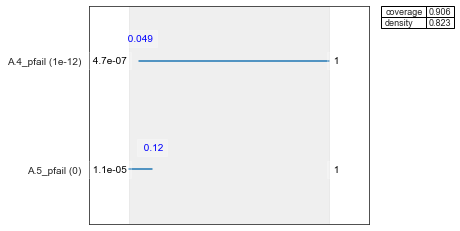

In [23]:
boxes[percentiles[1]][BOX].inspect(box_id)
boxes[percentiles[1]][BOX].inspect(box_id, style='graph')
plt.show()

In [24]:
lims = boxes[percentiles[1]][BOX].box_lims[box_id]

In [25]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["deaths " + str(percentiles[1])], "min": [lims["A.5_pfail"][0]], "max" :  [lims["A.5_pfail"][1]]})], axis=0)

# Visualisation

In [26]:
limits =limits.reset_index(drop=True)

In [27]:
limits

,outcome,min,max
0,damage 40,0.301639,0.999992
1,damage 90,0.000011,0.116059
2,deaths 40,0.264985,0.999992
3,deaths 90,0.000011,0.116077


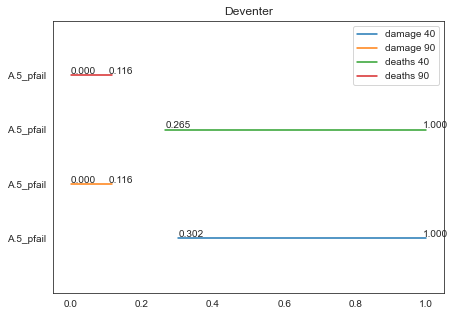

In [28]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
for index in limits.index:
    plt.plot([limits.loc[index]["min"],limits.loc[index]["max"]], [index,index])
    ax.annotate('{:.3f}'.format(limits.loc[index]["min"]),xy=(limits.loc[index]["min"],index +0.03))
    ax.annotate('{:.3f}'.format(limits.loc[index]["max"]),xy=(limits.loc[index]["max"]-0.01,index +0.03))
ax.grid(False)
ax.set_ylim([-1,4])
plt.legend(limits["outcome"].values)    
plt.yticks([0, 1,2, 3], ["A.5_pfail"]*4)
plt.title("Deventer")
plt.show()

In [29]:
gorssel_scen = pd.read_csv("simulation/optimisation/Gorssel/selected.csv")

In [30]:
A5_pfail = gorssel_scen["A.5_pfail"]

0.3315000871913685
0.4734949684889657
0.7634458449745021
0.0672905120062503
0.4957975824691399
0.4392029949386981


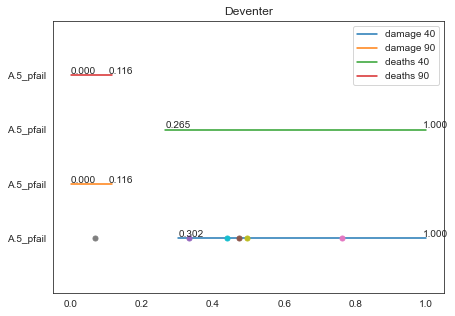

In [31]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
for index in limits.index:
    plt.plot([limits.loc[index]["min"],limits.loc[index]["max"]], [index,index])
    ax.annotate('{:.3f}'.format(limits.loc[index]["min"]),xy=(limits.loc[index]["min"],index +0.03))
    ax.annotate('{:.3f}'.format(limits.loc[index]["max"]),xy=(limits.loc[index]["max"]-0.01,index +0.03))

for pfail in A5_pfail:
    plt.plot(pfail, 0, markersize=5,  marker='o')
    print(pfail)
    
ax.grid(False)
ax.set_ylim([-1,4])
plt.legend(limits["outcome"].values)    
plt.yticks([0, 1, 2, 3], ["A.5_pfail"]*4)
plt.title("Deventer")
plt.show()

Looks like we got a decent distribution for the scenarios. At first sight it looks like the distribution is less optimal than for the others, but that's  because we only looked at A.5_pfail, in scen_disco for a better explanation. 